# TO BE RUN IN LOCAL
If you have a working environement, you don't need to run the following cells

In [ ]:
! git clone https://github.com/IVRL/LELSD.git

fatal: destination path 'LELSD' already exists and is not an empty directory.


In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install clip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!pip install --upgrade torch==1.9.1+cu111 torchvision==0.10.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -e ./CLIP
!pip install einops ninja
!git clone https://github.com/NVlabs/stylegan3
!git clone https://github.com/openai/CLIP
!pip install boto3
import sys
sys.path.append('./CLIP')
sys.path.append('./stylegan3')

import io
import os, time, glob
import pickle
import shutil
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
import requests
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import unicodedata
import re
from tqdm.notebook import tqdm
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from IPython.display import display
from einops import rearrange
import matplotlib.pyplot as plt
from google.colab import files

device = torch.device('cuda:0')
print('Using device:', device, file=sys.stderr)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/CLIP
     |████████████████████████████████| 53 kB 1.4 MB/s 
  Running setup.py develop for clip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'stylegan3' already exists and is not an empty directory.
fatal: destination path 'CLIP' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
Using device: cuda:0


# Manipulations

In [ ]:
#%cd LELSD/notebooks #If repository is cloned!

[Errno 2] No such file or directory: 'LELSD/notebooks'
/content


In [5]:
%cd drive/MyDrive/LELSD/notebooks #In Local 

[Errno 2] No such file or directory: 'drive/MyDrive/LELSD/notebooks #In Local'
/content


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import pickle
from copy import deepcopy
from tqdm import tqdm
import sys
import PIL
import cv2

sys.path.append("../")
import models
from lelsd import LELSD
from utils.biggan_utils import BigGANSampleGenerator
from utils.stylegan1_utils import StyleGAN1SampleGenerator
from utils.stylegan2_utils import StyleGAN2SampleGenerator
from utils.stylegan3_utils import StyleGAN3SampleGenerator
from utils.segmentation_utils import FaceSegmentation

#IMPORT UTILS FROM MICHAEL AND REMOVE THESE DEFINED FUNCTIONS


In [52]:
def load_pretrained_model(model_name, dataset_name):
    if model_name != "biggan":
        G = models.get_model(model_name,
                             f"../pretrained/{model_name}/{model2available_dataset[model_name][dataset_name]}")
    else:
        G = models.get_model(model_name, model2available_dataset[model_name][dataset_name])
    return G

def get_batch_data(sample_generator, seed, model_name, dataset_name, bs=10):
    batch_data = sample_generator.generate_batch(seed, return_image=True, return_style=True, batch_size=bs)
    return batch_data

In [16]:
dataset_name   = 'FFHQ',
truncation_psi = 0.7

idx2semantic = {
        "background": 0,
        "skin": 1,
        "brow": 2,
        "eye": 3,
        "eyeglass": 4,
        "ear": 5,
        "earrings": 6,
        "nose": 7,
        "mouth": 8,
        "neck": 9,
        "necklace": 10,
        "cloth": 11,
        "hair": 12,
        "hat": 13
}

In [53]:
def edit_image_stylegan2(sample_gen,ys,rgb_ys,alpha,c,L):
        modif = deepcopy(ys)
        modif[L][0,c] = modif[L][0,c] + alpha
        return sample_gen.generate_image_from_ys(modif, rgb_ys, raw=False)[0]

def edit_image_stylegan3(sample_gen,ys,alpha,c,L):
        modif = deepcopy(ys)
        modif[L][0,c] = modif[L][0,c] + alpha
        return sample_gen.generate_image_from_ys(modif, raw=False)[0]
        
def edit_get_all_infos_stylegan2(sample_gen,ys,rgb_ys,alpha,c,L):
        modif = deepcopy(ys)
        modif[L][0,c] = modif[L][0,c] + alpha
        return sample_gen.generate_batch_from_ys((modif, rgb_ys),return_image = True, return_all_layers = True)

def edit_get_all_infos_stylegan3(sample_gen,ys,alpha,c,L):
        modif = deepcopy(ys)
        modif[L][0,c] = modif[L][0,c] + alpha
        return sample_gen.generate_batch_from_ys(modif, return_image = True, return_all_layers = True)

        
def plotManip(imageModif, labels, layer, channel):
        n,r = imageModif.shape[:2]
        fig, ax = plt.subplots(n,3, figsize=(15,10))
        modif = ['-', 'original','+']
        for i in range(n):
          for j in range(r):
            typeModif = modif[j]
            ax[i,j].imshow(imageModif[i,j])
            if typeModif == 'original':
                ax[i,j].set_title(f"{typeModif}")
                ax[i,j].spines['bottom'].set_color('red')
                ax[i,j].spines['bottom'].set_linewidth(5)
                ax[i,j].spines['top'].set_color('red') 
                ax[i,j].spines['top'].set_linewidth(5)
                ax[i,j].spines['right'].set_color('red')
                ax[i,j].spines['right'].set_linewidth(5)
                ax[i,j].spines['left'].set_color('red')
                ax[i,j].spines['left'].set_linewidth(5)
            else:
                ax[i,j].set_title(f"{typeModif} {layer}_{channel[i]}")
          ax[i,0].set_ylabel('{} manip'.format(labels[i]))
        plt.tight_layout()
        plt.show()

In [60]:
model2available_dataset = {
    "stylegan2":{
        "FFHQ":"ffhq.pkl",
        },
    "stylegan3": {
        "FFHQ-R": "stylegan3-r-ffhqu-1024x1024.pkl",
        "FFHQ-T": "stylegan3-t-ffhqu-1024x1024.pkl",
        }
}

#StyleGAN2

In [20]:
model_name = 'stylegan2'
dataset_name = "FFHQ" 
G      = load_pretrained_model(model_name, dataset_name)
device     = torch.device('cuda') 
SG2 = StyleGAN2SampleGenerator(G=G, device=device, truncation_psi=truncation_psi) 
          
# 1/ image generated with random seed outside of range we used for ranking 
# 2/ we use the same image for all layer manipulations like they do in the paper 
data   = get_batch_data(SG2, 10400, model_name, dataset_name, bs=1) 
ys     = data['ys'] 
rgb_ys = data['rgb_ys']

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


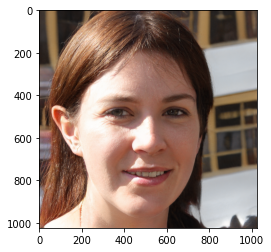

In [21]:
original = data['image'][0]
plt.imshow(original)

In [22]:
#Checking which are the top10 channels for 3 different semantics namely: hair, eyes and mouth:

def print_ranked_semantic_SG2(layer,semantics = ['hair', 'eyes', 'mouth'], number = 10):
  """
  layer: int, which layer we want the rank
  semantics: list of strings, for which semantics do we want the rank
  number: int, top number of channels
  """
  rankS2 = np.load('../logs/channelRankS2/rankL{}.npy'.format(layer))
  print('Layer :{}'.format(layer))
  for semantic in semantics:
    rankedS2H = np.argsort(rankS2[0][:,idx2semantic[semantic]])[::-1]
    print(f'{semantic}  :{rankedS2H[:number]}')


In [ ]:
#Layer 2 (= Layer 3 in the StyleSpace paper!)
print_ranked_semantic_SG2(2, semantics = ['hair', 'ears'])

In [25]:
alpha = 10

editedHairM    = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, -alpha, 169, 2)) #Taking the channel found in the top 10 that was also in their paper
editedHairP    = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, alpha, 169, 2))

editedEarsM    = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, -alpha, 412, 2))
editedEarsP    = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, alpha, 412, 2))


to_plot = np.asarray([[editedHairM, original,editedHairP],
                    [editedEarsM, original, editedEarsP]])
labels = ['hair', 'ears']
channels = [169, 412]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # This is added back by InteractiveShellApp.init_path()


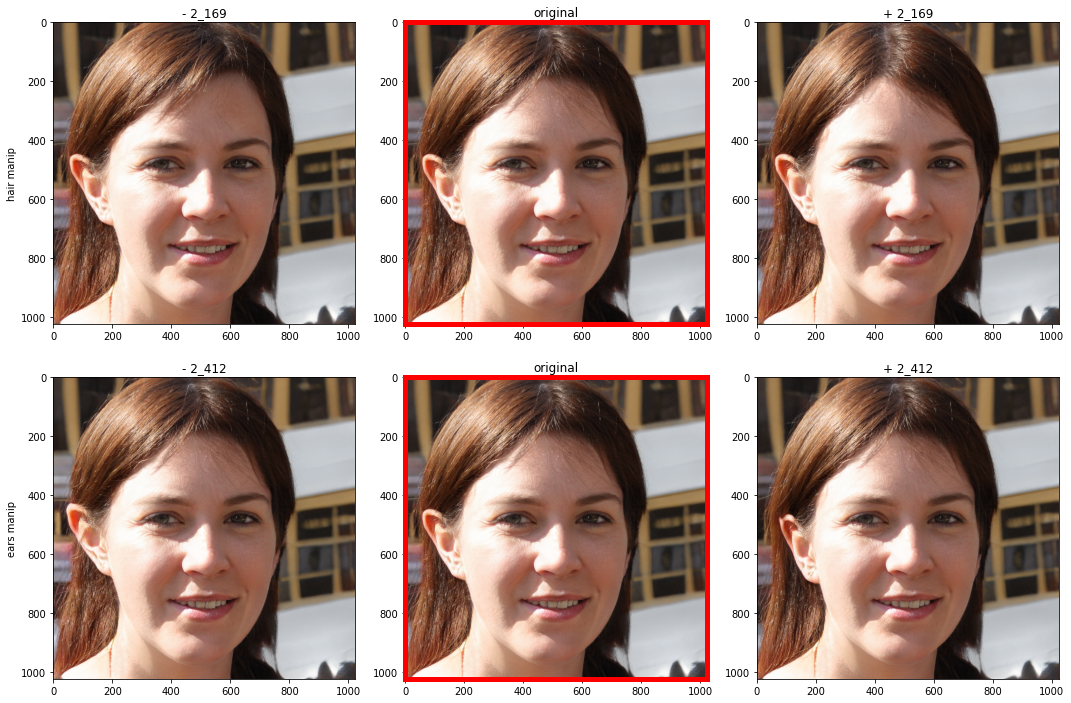

In [26]:
plotManip(to_plot, labels, 2, channels)

In [ ]:
#Layer 4 (= Layer 6 in the StyleSpace paper!)
print_ranked_semantic_SG2(4, semantics = ['hair', 'mouth'])

In [38]:
alpha = 10
editedHairM    = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, -alpha, 487, 4))
editedHairP    = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, alpha, 487, 4))


editedMouthM   = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, -alpha, 379, 4))
editedMouthP   = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, alpha, 379, 4))

labels = ['hair', 'mouth']
channels = [487, 379]
to_plot = np.asarray([[editedHairM, original,editedHairP],
                    [editedMouthM, original, editedMouthP]])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


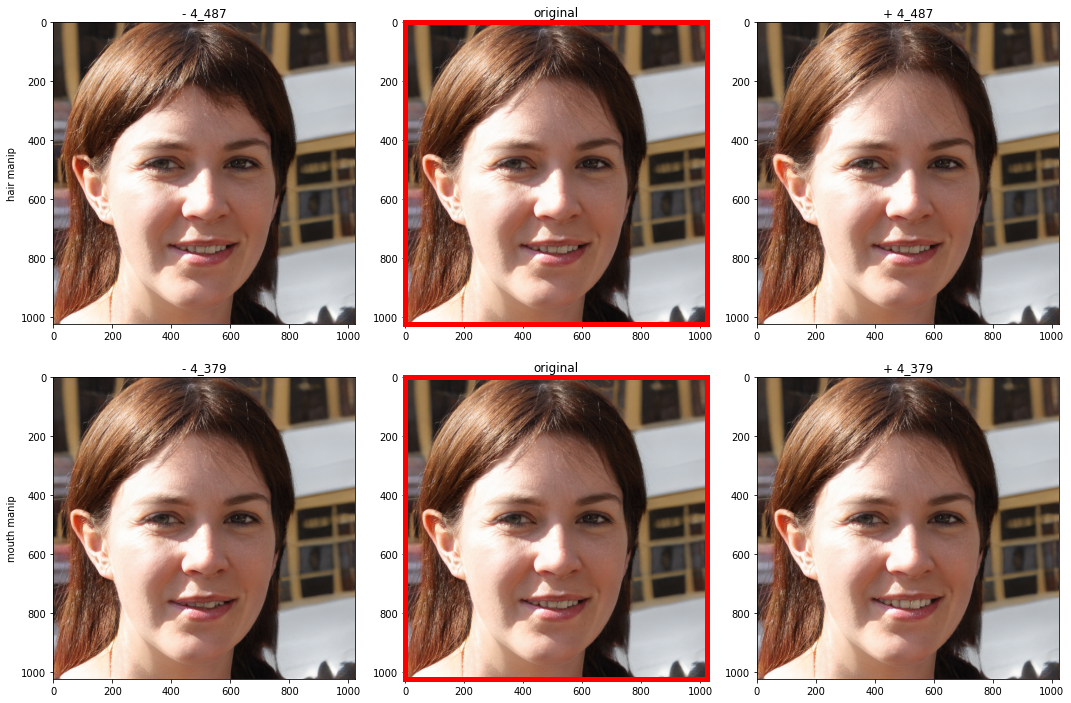

In [39]:
plotManip(to_plot, labels, 4, channels)

In [29]:
#Layer 6 (= Layer 9 in the StyleSpace paper!)
print_ranked_semantic_SG2(6, semantics = ['eye', 'eyebrows'])

FileNotFoundError: ignored

In [30]:
alpha = 10

editedEyeM    = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, -alpha, 409, 6))
editedEyeP    = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, alpha, 409, 6))

editedEyebrowsM    = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, -alpha, 340, 6))
editedEyebrowsP    = np.array(edit_image_stylegan2(SG2, ys, rgb_ys, alpha, 340, 6))

labels = ['eyes', 'eyebrows']
channels = [409, 340]
to_plot = np.asarray([[editedEyeM, original, editedEyeP],
                    [editedEyebrowsM,original, editedEyebrowsP]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == '':


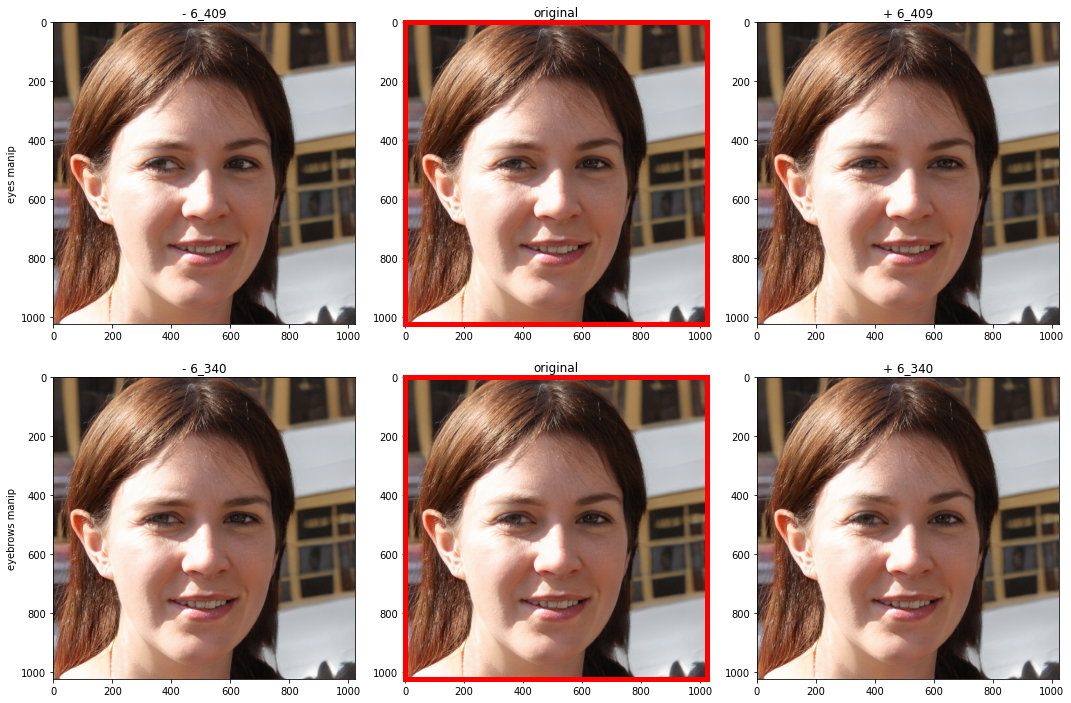

In [31]:
plotManip(to_plot, labels, 6, channels)

#GENERATE VIDEO FOR STYLEGAN2

In [40]:
def generate_video_SG2(duration, fps, layer_to_modify, channel_to_modify, features_maps,alpha = 10):
  """
  duration: int, duration of the video in seconds
  fps: int, frames per second
  layer_to_modify: int, which layer do we want to apply the transformation
  channel_to_modify: int, which channel we want to apply the transformation within the specified layer
  features_maps: list of tuples of the form (layer, channel). Creates a video of the specified features map. In order to have RGB, we take the specified channel
  + the 2 channels AFTER the one specified.

  output: Video of the modification + if specified, video of the feature maps
  """
  
  alphas = np.linspace(-alpha, alpha, duration*fps)

  videos = {"video_SG2":[]} #Creation of the dictionnary containing the video

  #Creation of the entries for the feature maps
  for (layer, channel) in features_maps:
    videos[f"l_{layer}_c{channel}"] = []
  
  for alpha in alphas:
    data = edit_get_all_infos_stylegan2(SG2,ys,rgb_ys,alpha,channel_to_modify,layer_to_modify)
    videos["video_SG2"].append(data['image'][0])
    for (layer, channel) in features_maps:
      videos[f"l_{layer}_c{channel}"].append(data[f'layer_{layer}'][0][channel:channel + 3])

  

  for key in videos:
    size = 0
    if key == 'video_SG2':
      size = videos[key][0].size
    else:
      size = videos[key][0].size()[1:3]
    
    print(size)
    out = cv2.VideoWriter(f'output_{key}.avi',cv2.VideoWriter_fourcc(*"MJPG"), fps, (size[0], size[1]))
    for i in range(fps * duration):
      if key == 'video_st2':
        img = np.array(videos[key][i], dtype='uint8')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      else:
        img = (videos[key][i].permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img = img.cpu().numpy()

    
      out.write(img)
    
    out.release()

In [43]:
generate_video_SG2(1,2, 6, 409, [(10,23)])

(1024, 1024)
torch.Size([128, 128])


#StyleGAN3-R part

In [61]:
model_name = 'stylegan3'
dataset_name = "FFHQ-R" 
G      = load_pretrained_model(model_name, dataset_name)
device     = torch.device('cuda') 
SG3 = StyleGAN3SampleGenerator(G=G, device=device, truncation_psi=truncation_psi) 
          
# 1/ image generated with random seed outside of range we used for ranking 
# 2/ we use the same image for all layer manipulations like they do in the paper 
data   = get_batch_data(SG3, 10200, model_name, dataset_name, bs=1) 
ys     = data['ys'] 

Setting up PyTorch plugin "filtered_lrelu_plugin"... Done.


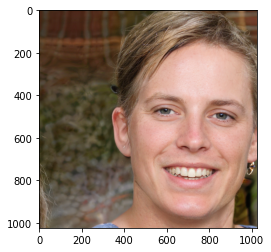

In [62]:
original = data['image'][0]
plt.imshow(original)

In [ ]:
#For styleGAN3, we decided to only take the top3 channels to save time
def print_ranked_semantic_SG3R(layer,semantics = ['hair', 'eyes', 'mouth'], number = 3):
  """
  layer: int, which layer we want the rank
  semantics: list of strings, for which semantics do we want the rank
  number: int, top number of channels
  """
  rankS3 = np.load('../logs/channelRankS3/rankL{}.npy'.format(layer))
  print('Layer :{}'.format(layer))
  for semantic in semantics:
    rankedS3H = np.argsort(rankS3[0][:,idx2semantic[semantic]])[::-1]
    print(f'{semantic}  :{rankedS3H[:number]}')

In [63]:
#Helper fucntion to generate the images to plot
def generate_to_plot(layer, channels,alpha = 50): #We set the alpha to 50 cause we noticed that with 10 we didn't get any noticeable differences
  to_plot = []
  for channel in channels:
    editedM   = np.array(edit_image_stylegan3(SG3, ys, -alpha, channel, layer))
    editedP   = np.array(edit_image_stylegan3(SG3, ys, alpha, channel, layer))
    to_plot.append([editedM, original, editedP])
  
  return np.asarray(to_plot)

## Layer 4

In [64]:
layer = 4
print_ranked_semantic_SG3R(layer)

NameError: ignored

### Hair

In [69]:
alpha = 50 
labels = ['hair', 'hair','hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The input object of type 'Image' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Image', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if __name__ == '__main__':


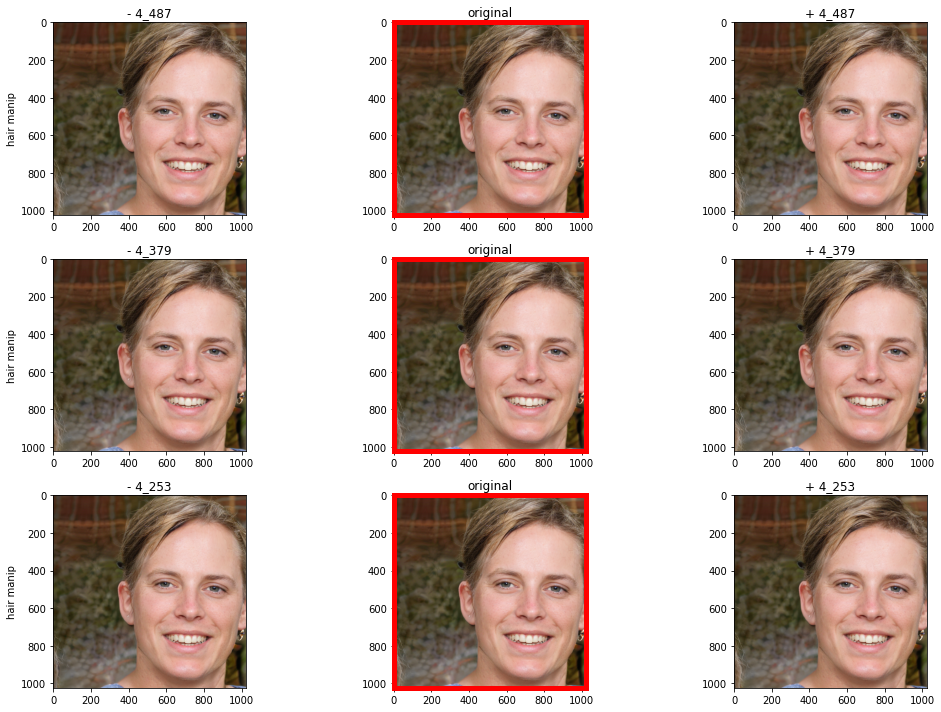

In [70]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth','mouth','mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

## Layer 5

In [ ]:
layer = 5
print_ranked_semantic_SG3R(layer)

### Hair

In [ ]:
alpha = 50 
labels = ['hair', 'hair', 'hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth', 'mouth', 'mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

## Layer 7

In [ ]:
layer = 7
print_ranked_semantic_SG3R(layer)

### Hair

In [ ]:
alpha = 50 
labels = ['hair', 'hair', 'hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth', 'mouth', 'mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

## Layer 8

In [ ]:
layer = 8
print_ranked_semantic_SG3R(layer)

### Hair

In [ ]:
alpha = 50 
labels = ['hair', 'hair', 'hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth', 'mouth', 'mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

## Generating video for StyleGAN3

In [73]:
def generate_video_SG3(duration, fps, layer_to_modify, channel_to_modify, features_maps, alpha = 50):
  
  """
  duration: int, duration of the video in seconds
  fps: int, frames per second
  layer_to_modify: int, which layer do we want to apply the transformation
  channel_to_modify: int, which channel we want to apply the transformation within the specified layer
  features_maps: list of tuples of the form (layer, channel). Creates a video of the specified features map. In order to have RGB, we take the specified channel
  + the 2 channels AFTER the one specified.

  output: Video of the modification + if specified, video of the feature maps
  """
  
  alphas = np.linspace(-alpha, alpha, duration*fps)

  videos = {"video_SG3":[]} #Creation of the dictionnary containing the video

  #Creation of the entries for the feature maps
  for (layer, channel) in features_maps:
    videos[f"l_{layer}_c{channel}"] = []
  
  for alpha in alphas:
    data = edit_get_all_infos_stylegan3(SG3,ys,alpha,channel_to_modify,layer_to_modify)
    videos["video_SG3"].append(data['image'][0])
    for (layer, channel) in features_maps:
      videos[f"l_{layer}_c{channel}"].append(data[f'layer_{layer}'][0][channel:channel + 3])

  

  for key in videos:
    size = 0
    if key == 'video_SG3':
      size = videos[key][0].size
    else:
      size = videos[key][0].size()[1:3]
    
    print(size)
    out = cv2.VideoWriter(f'output_{key}.avi',cv2.VideoWriter_fourcc(*"MJPG"), fps, (size[0], size[1]))
    for i in range(fps * duration):
      if key == 'video_SG3':
        img = np.array(videos[key][i], dtype='uint8')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      else:
        img = (videos[key][i].permute(1, 2, 0) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img = img.cpu().numpy()

    
      out.write(img)
    
    out.release()

In [74]:
generate_video_SG3(1,2, 6, 409, [(10,60)])

(1024, 1024)
torch.Size([512, 512])


In [75]:
# Function to generate images to be in the report
def plotMultiple_same_edits(imageSeed):
        fig, ax = plt.subplots(1,5, figsize=(15,10))

        layers = [8, 5, 8, 8,]
        channels = [295, 983, 102,879]
        data   = get_batch_data(SG3, imageSeed, model_name, dataset_name, bs=1) 
        ys = data['ys']
        ax[0].imshow(data['image'][0])
        ax[0].axis('off')
        s = zip(channels, layers)
        alphas = [50,50,50,-50]
        for i , my_tuple in enumerate(s):
          alpha = alphas[i]
          new_img = edit_image_stylegan3(SG3,ys,alpha,my_tuple[0],my_tuple[1])
          ax[i+1].imshow(new_img)
          ax[i+1].axis('off')

        plt.tight_layout()
        plt.show()

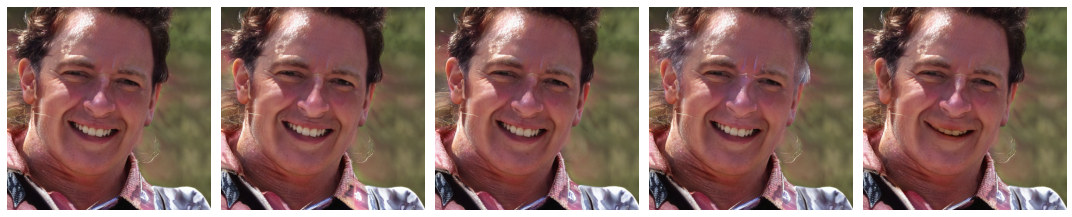

In [76]:
plotMultiple_same_edits(10206)

#StyleGAN3-T part

In [80]:
model_name = 'stylegan3'
dataset_name = "FFHQ-T" 
G      = load_pretrained_model(model_name, dataset_name)
device     = torch.device('cuda') 
SG3 = StyleGAN3SampleGenerator(G=G, device=device, truncation_psi=truncation_psi) 
          
# 1/ image generated with random seed outside of range we used for ranking 
# 2/ we use the same image for all layer manipulations like they do in the paper 
data   = get_batch_data(SG3, 10000, model_name, dataset_name, bs=1) #Sadly we don't remember the image seed that we put in the paper...
ys     = data['ys'] 

In [78]:
def print_ranked_semantic_SG3T(layer,semantics = ['hair', 'eyes', 'mouth'], number = 3):
  """
  layer: int, which layer we want the rank
  semantics: list of strings, for which semantics do we want the rank
  number: int, top number of channels
  """
  rankS3 = np.load('../logs/channelRankS3/rankL{}.npy'.format(layer))
  print('Layer :{}'.format(layer))
  for semantic in semantics:
    rankedS3H = np.argsort(rankS3[0][:,idx2semantic[semantic]])[::-1]
    print(f'{semantic}  :{rankedS3H[:number]}')

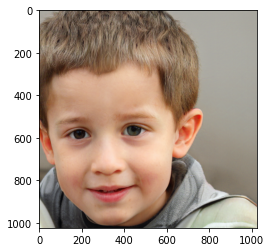

In [106]:
original = data['image'][0]
plt.imshow(original)

## Layer 4

In [ ]:
layer = 4
print_ranked_semantic_SG3T(layer)

### Hair

In [ ]:
alpha = 50 
labels = ['hair', 'hair', 'hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth', 'mouth', 'mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

## Layer 5

In [46]:
layer = 5
print_ranked_semantic_SG3T(layer)

NameError: ignored

### Hair

In [ ]:
alpha = 50 
labels = ['hair', 'hair', 'hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth', 'mouth', 'mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

## Layer 6

In [ ]:
layer = 6
print_ranked_semantic_SG3T(layer)

### Hair

In [ ]:
alpha = 50 
labels = ['hair', 'hair', 'hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth', 'mouth', 'mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

## Layer 7

In [ ]:
layer = 7
print_ranked_semantic_SG3T(layer)

### Hair

In [ ]:
alpha = 50 
labels = ['hair', 'hair', 'hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth', 'mouth', 'mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

## Layer 8

In [ ]:
layer = 8
print_ranked_semantic_SG3T(layer)

### Hair

In [ ]:
alpha = 50 
labels = ['hair', 'hair', 'hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth', 'mouth', 'mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

## Layer 9

In [ ]:
layer = 9
print_ranked_semantic_SG3T(layer)

### Hair

In [ ]:
alpha = 50 
labels = ['hair', 'hair', 'hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth', 'mouth', 'mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

## Layer 10

In [ ]:
layer = 10
print_ranked_semantic_SG3T(layer)

### Hair

In [ ]:
alpha = 50 
labels = ['hair', 'hair', 'hair']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Mouth

In [ ]:
alpha = 50 
labels = ['mouth', 'mouth', 'mouth']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)

### Eyes

In [ ]:
alpha = 50 
labels = ['eye', 'eye', 'eye']
channels = [487, 379, 253]

to_plot = generate_to_plot(layer, channels)

In [ ]:
plotManip(to_plot, labels, layer, channels)